# Brain Tumor Detection Using DL

The main purpose of this project is detecting tumors from MRI scans. 

source: [kaggle](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

### Import necessary modules

In [10]:
import os
import cv2
import shutil

from tqdm import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



## Splitting the data

In [4]:
img_dir = '../../Datasets/brain_tumor_dataset/'
img_dir_data = '../../Datasets/brain_tumor_dataset/data/'
for category in os.listdir(img_dir_data):
    if not category.startswith('.'):
        img_num = len(os.listdir(img_dir_data+category))
        for n, img_name in enumerate(os.listdir(img_dir_data+category)):
            img = img_dir_data + category + '/' + img_name
            if n < 5:
                shutil.copy(img, 'TEST/' + category.upper() + '/' + img_name)
            elif n < 0.8*img_num:
                shutil.copy(img, 'TRAIN/' + category.upper() + '/' + img_name)
            else:
                shutil.copy(img, 'VAL/' + category.upper() + '/' + img_name)

## Data Import and Preprocessing

In [57]:
def load_data(dir_path, img_size=(100,100)):
    """ Load Images as np.arrays
    :params:
    :return:
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(os.listdir(dir_path)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path+path+'/'+file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} image loaded from {dir_path} directory.')
    return X, y, labels

In [58]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 3/3 [00:00<00:00, 33.78it/s]

193 image loaded from TRAIN/ directory.
10 image loaded from TEST/ directory.
50 image loaded from VAL/ directory.


In [72]:
train_dist = np.array(np.unique(y_train, return_counts = True)).T
test_dist = np.array(np.unique(y_test, return_counts = True)).T
val_dist = np.array(np.unique(y_val, return_counts = True)).T

In [110]:
data_dist = pd.DataFrame({'Train':train_dist[:,1],'Val':val_dist[:,1], 'Test':test_dist[:,1]})
data_dist

,Train,Val,Test
0,74,19,5
1,119,31,5


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [9]:
# Define the training and validation base directories
training_dir = '../../Datasets/brain_tumor_dataset/training'
validation_dir = '../../Datasets/brain_tumor_dataset/validation'

#Directorey with training negative tumor
train_no_dir = os.path.join(training_dir, 'no')
#Directorey with training positive tumor
train_yes_dir = os.path.join(training_dir, 'yes')

#Directorey with validation negative tumor
validation_no_dir = os.path.join(validation_dir, 'no')
#Directorey with validation positive tumor
validation_yes_dir = os.path.join(validation_dir, 'yes')

print(f"There are {len(os.listdir(train_no_dir))} images of training negative tumor.")
print(f"There are {len(os.listdir(train_yes_dir))} images of training positive tumor.")
print(f"There are {len(os.listdir(validation_no_dir))} images of validation negative tumor.")
print(f"There are {len(os.listdir(validation_yes_dir))} images of validation positive tumor.")

There are 87 images of training negative tumor.
There are 144 images of training positive tumor.
There are 10 images of validation negative tumor.
There are 10 images of validation positive tumor.


In [39]:
def plot_mri(dir, label):
    negative_dir = os.path.join(dir, 'no')
    positive_dir = os.path.join(dir, 'yes')
    negative_names = os.listdir(negative_dir)
    positive_names = os.listdir(positive_dir)

    fig = plt.gcf()
    fig.set_size_inches(12,6)
    n_random_idx = np.random.randint(len(negative_names), size=4)
    p_random_idx = np.random.randint(len(positive_names), size=4)

    random_negative = [os.path.join(negative_dir, negative_names[idx]) for idx in n_random_idx]
    random_positive = [os.path.join(positive_dir, positive_names[idx]) for idx in p_random_idx]
    print(f"Images from {label} dataset:")
    for i, name in enumerate(random_negative+random_positive):
        sq = plt.subplot(2,4,i+1)
        sq.axis('Off')
        img = cv2.imread(name)
        plt.imshow(img)
    

Images from training dataset:


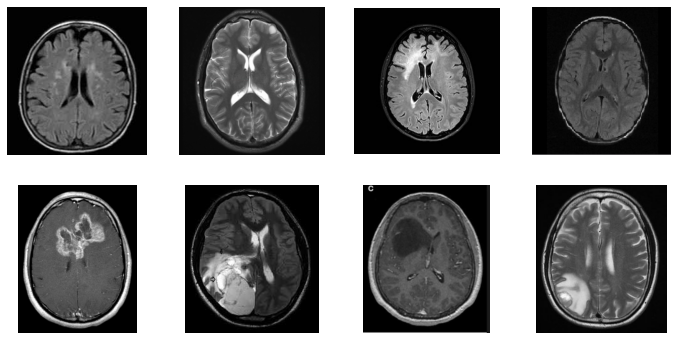

In [40]:
# Load random positive(top) and negative(bottom) images from training set
plot_mri(training_dir, 'training')

Images from validation dataset:


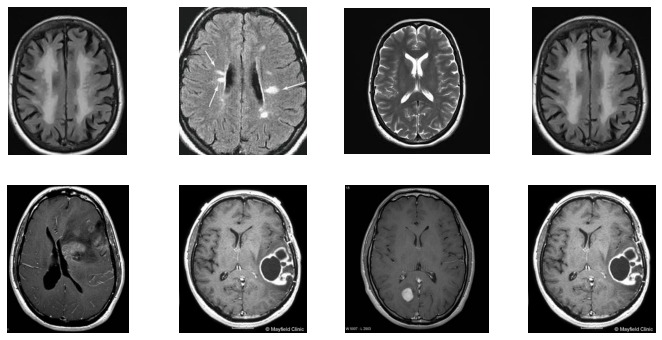

In [42]:
# Load random positive(top) and negative(bottom) images from validation set
plot_mri(validation_dir, 'validation')

In [44]:
# Training and Validation Generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Generate batches of tensor image data with real-time data augmentation.
    
    Args:
        TRAINING_DIR (str): Path to training directory
        VALIDATION_DIR (str): Path to validation directory
    Returns:
        train_generator
        validation_generator
    """
    # Instantiate the ImageDataGenerator class, rescale and augment the images
    train_datagen = ImageDataGenerator(rescale=1/255.0,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearesr')
    
    # Pass in the training directory to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=8,
                                                        target_size=(300,300),
                                                        class_mode='binary')

    # Instantiate the ImageDataGenerator with rescale
    validation_datagen = ImageDataGenerator(rescale=1/255.0)

    # Pass in the validation directory to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                  batch_size=2,
                                                                  target_size=(300,300),
                                                                  class_mode='binary')

    return train_generator, validation_generator

In [45]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 229 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_directory(
    '../../Datasets/brain_tumor_dataset',
    target_size = (300,300),
    batch_size = 16,
    class_mode = 'binary'
)

Found 249 images belonging to 2 classes.


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1,  activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [6]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(train_generator,
                    steps_per_epoch = 16,
                    epochs = 15, 
                    verbose = 1)

Epoch 1/15
16/16 [==============================] - 8s 477ms/step - loss: 0.7161 - accuracy: 0.6386
Epoch 2/15
16/16 [==============================] - 8s 469ms/step - loss: 0.5622 - accuracy: 0.7028
Epoch 3/15
16/16 [==============================] - 8s 486ms/step - loss: 0.5007 - accuracy: 0.7751
Epoch 4/15
16/16 [==============================] - 8s 493ms/step - loss: 0.4532 - accuracy: 0.8072
Epoch 5/15
16/16 [==============================] - 8s 465ms/step - loss: 0.3836 - accuracy: 0.8474
Epoch 6/15
16/16 [==============================] - 8s 480ms/step - loss: 0.3277 - accuracy: 0.8554
Epoch 7/15
16/16 [==============================] - 8s 463ms/step - loss: 0.2383 - accuracy: 0.9197
Epoch 8/15
16/16 [==============================] - 7s 459ms/step - loss: 0.2011 - accuracy: 0.9197
Epoch 9/15
16/16 [==============================] - 7s 457ms/step - loss: 0.1694 - accuracy: 0.9317
Epoch 10/15
16/16 [==============================] - 7s 461ms/step - loss: 0.1596 - accuracy: 0.9197

In [10]:
tests = [name for name in os.listdir('./test') if not name.startswith('.')]
for name in tests:
    test_path = os.path.join('./test', name)
    img = image.load_img(test_path, target_size=(300,300))
    x = image.img_to_array(img)/255.0
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images)
    print(classes[0])
    if classes[0]>0.5:
        print(name + " is a Tumor")
    else:
        print(name + " is a Not Tumor")

[0.9990076]
Y1.jpg is a Tumor
[0.9999813]
Y2.jpg is a Tumor
[2.7980288e-06]
No2.jpg is a Not Tumor
[0.00025263]
No1.jpg is a Not Tumor
